# CNN for Shape Dimensions: Z3

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchvision import transforms 
from torch.utils.data import DataLoader

from data_load import ShapeDimensionDataset
import regression

## SETTINGS

In [2]:
IMAGE_SIZE = 150
BATCH_SIZE = 32

## Datasets and Dataloaders

omit test for the time being ...

In [3]:
parameters = ["h","tw","bf","rf","ba","ra","blf","rlf"]
target_cols = ["h_scaled","tw_scaled","ba_scaled","ra_scaled","bf_scaled","rf_scaled","blf_scaled","rlf_scaled"]

flip_transform = regression.flip_transform(IMAGE_SIZE)
no_transform = regression.no_transform(IMAGE_SIZE)

datasets = {
    'train': ShapeDimensionDataset("dataset/Z3_train.csv", 
                                   "dataset/train/Z3/",
                                   transform=flip_transform, 
                                   target_cols=target_cols),
    'val': ShapeDimensionDataset("dataset/Z3_val.csv", 
                                 "dataset/val/Z3/",
                                 transform=flip_transform, 
                                 target_cols=target_cols),    
}

In [4]:
dataloaders = {'train': DataLoader(datasets['train'], 
                                   batch_size=BATCH_SIZE,
                                   shuffle=True, 
                                   num_workers=6),
               'val': DataLoader(datasets['val'], 
                                 batch_size=BATCH_SIZE,
                                 shuffle=False, 
                                 num_workers=6),                                       
    }


## Show something

Convert PIL grayscale image (type=L) to np array (axes are still flipped):

`img = np.frombuffer(img_.tobytes(), dtype=np.uint8).reshape(224,224)`

Convert torch.Tensor to np array:



pixel value range: 0.0 1.0
shape: (150, 150)
dtype: float32
[[0.39868013]
 [0.17643161]
 [0.70082062]
 [0.01807366]
 [0.61695622]
 [0.02133109]
 [0.74271797]
 [0.65688308]]


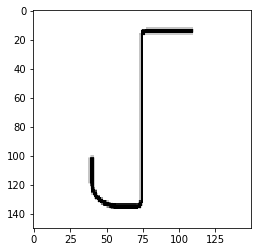

In [8]:
ds = datasets['train']

img_, y = ds[68]  
# TODO: how to rotate ???
img = img_[0].numpy() # shape(1,224,224) -> shape(224,224)
img = img.squeeze()
print("pixel value range:", np.min(img), np.max(img))
# TODO: these are grayscale (B/W) pictures. One depth dimension is enough.
print("shape:", img.shape)
print("dtype:", img.dtype)
print(y)
plt.imshow(img, cmap='gray');



In [9]:
def plot_history(history, log=False):
    """history plot, return image"""
    fig, ax = plt.subplots()
    ax.plot(history['train'], "o-", label="train")
    ax.plot(history['val'], "o-", label="val")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    if log:
        ax.semilogy()
    ax.grid()
    ax.legend()

## Settings

In [10]:
lr = 0.001

model = regression.Net1(len(parameters), image_size=IMAGE_SIZE, param_names=parameters, description="Z3")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
print(model)
 

Net1(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4624, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=8, bias=True)
)


Epoch 1/50: train Loss: 0.038567 val Loss: 0.023652 

Epoch 2/50: train Loss: 0.017234 val Loss: 0.011239 

Epoch 3/50: train Loss: 0.008884 val Loss: 0.005645 

Epoch 4/50: train Loss: 0.004204 val Loss: 0.003098 

Epoch 5/50: train Loss: 0.002885 val Loss: 0.002272 

Epoch 6/50: train Loss: 0.002289 val Loss: 0.002304 

Epoch 7/50: train Loss: 0.001973 val Loss: 0.002051 

Epoch 8/50: train Loss: 0.001579 val Loss: 0.001415 

Epoch 9/50: train Loss: 0.001443 val Loss: 0.001669 

Epoch 10/50: train Loss: 0.001373 val Loss: 0.001192 

Epoch 11/50: train Loss: 0.001137 val Loss: 0.001103 

Epoch 12/50: train Loss: 0.001063 val Loss: 0.001372 

Epoch 13/50: train Loss: 0.000988 val Loss: 0.001103 

Epoch 14/50: train Loss: 0.000933 val Loss: 0.000887 

Epoch 15/50: train Loss: 0.000832 val Loss: 0.000780 

Epoch 16/50: train Loss: 0.000788 val Loss: 0.000860 

Epoch 17/50: train Loss: 0.000790 val Loss: 0.000676 

Epoch 18/50: train Loss: 0.000688 val Loss: 0.000771 

Epoch 19/50: train 

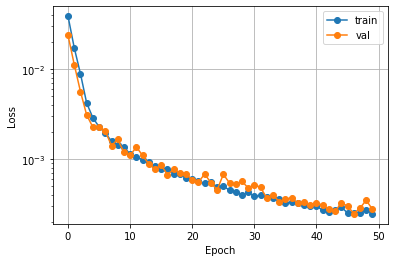

In [39]:
if 1 == 0:
    hist = regression.train_regression(model, dataloaders, criterion, optimizer, num_epochs=50)
    plot_history(hist, log=True)
    model.save_checkpoint("models/Z3_flip_50.pt")

Ah, great! It works!

In [40]:
import json
with open("history_Z3_flip_50.json", "w") as fp:
    json.dump(hist, fp, indent=2)

# Inference

### Utilities

In [11]:
from sklearn.preprocessing import MinMaxScaler
import pickle
import pandas as pd
from sections import VERTEX_FUNCTIONS

func, params = VERTEX_FUNCTIONS['z3']
print(params)

def imshow(tensor):
    """show first image in a tensor"""
    img = tensor[0].numpy() # shape(1,224,224) -> shape(224,224)
    img = img.squeeze()
    plt.imshow(img, cmap='gray');


['h', 'tw', 'ba', 'ra', 'bf', 'rf', 'blf', 'rlf']


In [12]:
model = regression.Net1.from_checkpoint("models/Z3_flip_50.pt")

# scaler
with open("dataset/Z3_scaler.pkl", "rb") as fp:
    scaler = pickle.load(fp)

Z3
Input size: 150, output size: 8
parameter names: h, tw, bf, rf, ba, ra, blf, rlf


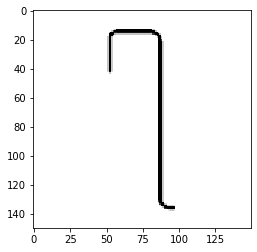

In [13]:
i = 60
area = 200

# get data point
ds = datasets['val']
image, target = ds[i]
# show image and target
imshow(image)

In [15]:
img = image.reshape(1, 1, IMAGE_SIZE, IMAGE_SIZE)
print(img.shape)
print(img.dtype)
print(img.max())
with torch.no_grad():
    model.eval()
    outputs = model.forward(img)
    outputs = outputs.numpy()
    
# print raw target / output
print(params)

print("target (scaled): ", target.squeeze())
print("output (scaled): ", outputs.squeeze())

# unscale both, multiply with reference length (sqrt(A))
target_dim = np.sqrt(area) * scaler.inverse_transform(target.T)
target_dim = target_dim.squeeze()
output_dim = np.sqrt(area) * scaler.inverse_transform(outputs)
output_dim = output_dim.squeeze()
print("target (unscaled): ", target_dim)
print("output (unscaled): ", output_dim)

# generate vertices

torch.Size([1, 1, 150, 150])
torch.float32
tensor(1.)
['h', 'tw', 'ba', 'ra', 'bf', 'rf', 'blf', 'rlf']
target (scaled):  [0.74224127 0.0780218  0.15561773 0.20677663 0.88431896 0.24519446
 0.77278452 0.1246048 ]
output (scaled):  [0.753297   0.08104907 0.1652003  0.20093608 0.8872881  0.2473319
 0.7610101  0.11437809]
target (unscaled):  [96.22189971  1.37459857  8.2475914   4.1237957  28.86656991  4.1237957
 21.99357708  2.74919713]
output (unscaled):  [96.8766     1.3789954  8.502716   4.0431294 28.934351   4.14868
 21.7006     2.6270788]


In [16]:
# show results
df = pd.DataFrame([target_dim, output_dim], index=['true', 'predicted'], 
                  columns=params)
df.round(2)

,h,tw,ba,ra,bf,rf,blf,rlf
true,96.22,1.37,8.25,4.12,28.87,4.12,21.99,2.75
predicted,96.88,1.38,8.50,4.04,28.93,4.15,21.70,2.63


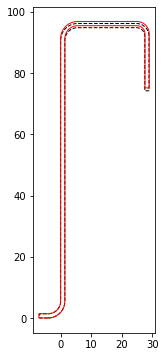

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))

# generate polygons
true_o, true_i = func(*target_dim.squeeze())
pred_o, pred_i = func(*output_dim.squeeze())


for outer in true_o:
    mppoly = plt.Polygon(outer, ec="k", ls='--', fill=False, linewidth=1)
    ax.add_patch(mppoly)
for inner in true_i:
    mppoly = plt.Polygon(inner, ec="k", ls='--', fill=False, linewidth=1)
    ax.add_patch(mppoly)
    
for outer in pred_o:
    mppoly = plt.Polygon(outer, ec="r", fill=False, linewidth=1)
    ax.add_patch(mppoly)
for inner in pred_i:
    mppoly = plt.Polygon(inner, ec="r", fill=False, linewidth=1)
    ax.add_patch(mppoly)

ax.autoscale(tight=False)
ax.set_aspect("equal")
#ax.axis("off");


### Evaluate: Compute IOU

In [31]:
# to be completed

### Full Loop: Input polygon vertices, create image 

In [ ]:
# to be completed